# Decoding the Surface Code

In this experiment, we decode the Surface code which protects a single qubit from all types of errors by using ``mdopt``. Here, we demonstrate direct-error input decoding, which means that the decoder takes a Pauli error as input and outputs the most likely logical operator. This pipeline is sufficient for threshold computation. In reality, the decoder could be shown a syndrome measurement, from which possible error patterns would be sampled. After each run, the algorithm yields a probability distribution over the Pauli operators (I, X, Z, Y) to apply to the encoded logical qubit. Hereafter, we assume an independent noise model as well as perfect syndrome measurements. We will create a Surface Code instance via the Hypergraph Product of two repetition codes since this construction yields a 2D lattice with stabilizers suitable for the Surface Code's structure.

In [1]:
import sys

sys.path.append("../")
sys.path.append("../..")

import numpy as np
import qecstruct as qec
import qecsim.paulitools as pt
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import FuncFormatter, FormatStrFormatter
from tqdm import tqdm
from scipy.stats import sem

from mdopt.mps.utils import create_custom_product_state, find_orth_centre
from mdopt.contractor.contractor import mps_mpo_contract
from mdopt.optimiser.utils import (
    SWAP,
    COPY_LEFT,
    XOR_BULK,
    XOR_LEFT,
    XOR_RIGHT,
)

from examples.decoding.decoding import (
    css_code_checks,
    css_code_logicals,
    css_code_logicals_sites,
    css_code_constraint_sites,
    apply_constraints,
    apply_bitflip_bias,
    apply_depolarising_bias,
    decode_custom,
    pauli_to_mps,
    decode_css,
    css_code_stabilisers,
    multiply_pauli_strings,
    map_distribution_to_pauli,
    generate_pauli_error_string,
)
from examples.decoding.visualisation import plot_parity_check_mpo
from mdopt.optimiser.dephasing_dmrg import DephasingDMRG
import numpy as np
import qecstruct as qec
import qecsim.paulitools as pt
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import FuncFormatter, FormatStrFormatter
from tqdm import tqdm
from scipy.stats import sem

from mdopt.mps.utils import create_custom_product_state, inner_product, create_simple_product_state
from mdopt.contractor.contractor import mps_mpo_contract
from mdopt.optimiser.utils import (
    SWAP,
    COPY_LEFT,
    XOR_BULK,
    XOR_LEFT,
    XOR_RIGHT,
)

from examples.decoding.decoding import (
    css_code_checks,
    css_code_logicals,
    css_code_logicals_sites,
    css_code_constraint_sites,
    apply_constraints,
    apply_bitflip_bias,
    apply_depolarising_bias,
    decode_custom,
    pauli_to_mps,
    decode_css,
    css_code_stabilisers,
    multiply_pauli_strings,
    map_distribution_to_pauli,
    generate_pauli_error_string,
)
from examples.decoding.visualisation import plot_parity_check_mpo

In [2]:
bond_dimss = [20]
overlaps = []

chi_max = 20


100%|██████████| 192/192 [01:05<00:00,  2.91it/s]


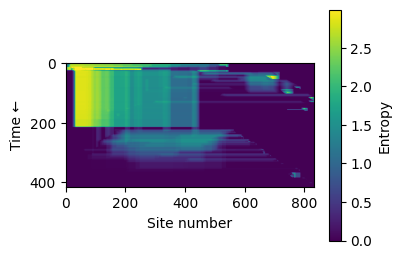

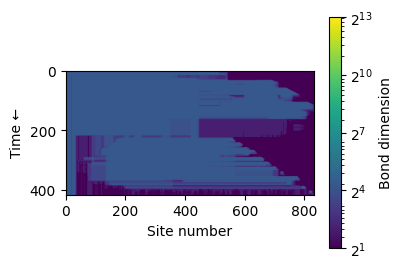

0.9995033103404458


In [4]:
for chi_max in bond_dimss:
    print(f"chi_max = {chi_max}")
    SEED = 123
    NUM_BITS = 16
    CHECK_DEGREE, BIT_DEGREE = 4, 3
    NUM_CHECKS = int(NUM_BITS * BIT_DEGREE / CHECK_DEGREE)
    if NUM_BITS / NUM_CHECKS != CHECK_DEGREE / BIT_DEGREE:
        raise ValueError("The Tanner graph of the code must be bipartite.")

    seed_seq = np.random.SeedSequence(SEED)

    classical_code = qec.random_regular_code(
        NUM_BITS, NUM_CHECKS, BIT_DEGREE, CHECK_DEGREE, qec.Rng(SEED)
    )
    code = qec.hypergraph_product(classical_code, classical_code)

    num_logicals = code.num_x_logicals() + code.num_z_logicals()
    num_sites = 2 * len(code) + num_logicals

    error_state = "10101010" + "0" * (num_sites - num_logicals - 8)
    logicals_state = "+" * num_logicals
    state_string = logicals_state + error_state
    error_mps = create_custom_product_state(
        string=state_string, tolerance=0, form="Right-canonical"
    )
    checks_x, checks_z = css_code_checks(code)
    constraints_tensors = [XOR_LEFT, XOR_BULK, SWAP, XOR_RIGHT]
    logicals_tensors = [COPY_LEFT, XOR_BULK, SWAP, XOR_RIGHT]
    constraint_sites = css_code_constraint_sites(code)
    logicals_sites = css_code_logicals_sites(code)

    renormalise = True
    sites_to_bias = list(range(num_logicals, num_sites))
    error_mps = apply_bitflip_bias(
        mps=error_mps,
        prob_bias_list=0.1,
        sites_to_bias=sites_to_bias,
    )
    entropies, bond_dims = [], []

    # for the X and the Z logicals
    for i in [0, 1]:
        error_mps, entrps, bnd_dims = apply_constraints(
            error_mps,
            logicals_sites[i],
            logicals_tensors,
            chi_max=chi_max,
            cut=0,
            renormalise=renormalise,
            strategy="Optimised",
            return_entropies_and_bond_dims=True,
        )
        entropies += entrps
        bond_dims += bnd_dims

    # for the X and the Z checks
    for i in [0, 1]:
        error_mps, entrps, bnd_dims = apply_constraints(
            error_mps,
            constraint_sites[i],
            constraints_tensors,
            chi_max=chi_max,
            cut=0,
            renormalise=renormalise,
            strategy="Optimised",
            return_entropies_and_bond_dims=True,
        )
        entropies += entrps
        bond_dims += bnd_dims

    plt.figure(figsize=(4, 3))
    plt.imshow(entropies, cmap="viridis")
    plt.colorbar(label="Entropy")
    plt.xlabel("Site number")
    plt.ylabel("Time ←")
    plt.show()

    plt.figure(figsize=(4, 3))
    plt.imshow(bond_dims, cmap="viridis", norm=LogNorm(vmin=2**1, vmax=2**13))
    cbar = plt.colorbar(
        label="Bond dimension",
        format=FuncFormatter(lambda x, pos: f"$2^{{{int(np.log2(x))}}}$"),
        ticks=[2**i for i in range(1, 14, 3)],
    )
    plt.ylabel("Time ←")
    plt.xlabel("Site number")
    plt.show()

    sites_to_marginalise = list(range(num_logicals, len(error_state) + num_logicals))
    logical = error_mps.marginal(sites_to_marginalise=sites_to_marginalise, renormalise=renormalise)
    num_logical_sites = len(logical)
    overlap = inner_product(
        create_simple_product_state(which="0", num_sites=len(logical)),
        logical,
    )
    overlaps.append(
        overlap
    )
    print(overlap)

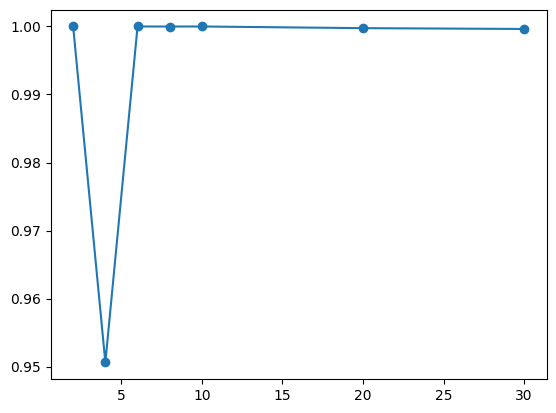

In [12]:
plt.plot(
    bond_dimss,
    overlaps,
    marker="o",
)
plt.show()

In [ ]:
mps_dmrg_start = create_simple_product_state(num_logical_sites, which="+")
mps_dmrg_target = create_simple_product_state(num_logical_sites, which="0")
engine = DephasingDMRG(
    mps=mps_dmrg_start,
    mps_target=logical,
    chi_max=chi_max,
    cut=0,
    mode="LA",
    silent=False,
)
engine.run(num_iter=10)
mps_dmrg_final = engine.mps
overlap = abs(inner_product(mps_dmrg_final, mps_dmrg_target))
print(f"Overlap with the target state: {overlap:.4f}")

In [ ]:
strategy = "Optimised"
logical_values = [[] for _ in range(4)]

for max_bond_dim in tqdm(bond_dims):
    error_state = "0" * (num_sites - num_logicals)
    logicals_state = "+" * num_logicals
    state_string = logicals_state + error_state
    error_mps = create_custom_product_state(
        string=state_string, tolerance=0, form="Right-canonical"
    )

    error_mps = apply_bitflip_bias(
        mps=error_mps,
        prob_bias_list=0.1,
        sites_to_bias=sites_to_bias,
    )
    for i in [0, 1]:
        error_mps = apply_constraints(
            error_mps,
            logicals_sites[i],
            logicals_tensors,
            renormalise=renormalise,
            strategy=strategy,
            chi_max=max_bond_dim,
            cut=0,
            silent=True,
        )
    for i in [0, 1]:
        error_mps = apply_constraints(
            error_mps,
            constraint_sites[i],
            constraints_tensors,
            renormalise=renormalise,
            strategy=strategy,
            chi_max=max_bond_dim,
            cut=0,
            silent=True,
        )

    sites_to_marginalise = list(range(num_logicals, len(error_state) + num_logicals))
    logical = error_mps.marginal(sites_to_marginalise=sites_to_marginalise).dense(
        flatten=True, renormalise=renormalise, norm=1
    )

    for i in range(4):
        logical_values[i].append(logical[i])

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(inv_bond_dims, logical_values[0], marker="o", label=f"Pr(I)")
plt.xlabel("Inverse Max Bond Dimension")
plt.ylabel("Logical Value")
plt.title("Logical Values vs Bond Dimension (Optimised)")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(inv_bond_dims, logical_values[1], marker="o", label=f"Pr(X)")
plt.plot(inv_bond_dims, logical_values[2], marker="o", label=f"Pr(Z)")
plt.plot(inv_bond_dims, logical_values[3], marker="o", label=f"Pr(Y)")
plt.xlabel("Inverse Max Bond Dimension")
plt.ylabel("Logical Value")
plt.title("Logical Values vs Bond Dimension (Optimised)")
plt.grid(True)
plt.legend()
plt.show()

Let's now put all of this into a function. We'll need this to run the decoder over a bunch of single- and multiqubit errors. For this, we first generate all possible one-qubit errors and 20 two-qubit errors using `qecsim`.

In [ ]:
one_qubit_paulis = list(pt.ipauli(n_qubits=len(code), min_weight=1, max_weight=1))
two_qubit_paulis = list(pt.ipauli(n_qubits=len(code), min_weight=2, max_weight=2))[:20]

In [ ]:
one_qubit_outputs = [
    decode_css(
        code,
        error,
        renormalise=renormalise,
        silent=True,
        bias_prob=0,
    )
    for error in tqdm(one_qubit_paulis)
]
one_qubit_corrections_distribution = [output[0] for output in one_qubit_outputs]

In [ ]:
two_qubit_outputs = [
    decode_css(
        code,
        error,
        renormalise=renormalise,
        silent=True,
        bias_prob=0.001,
    )
    for error in tqdm(two_qubit_paulis[:20])
]
two_qubit_corrections_distribution = [output[0] for output in two_qubit_outputs]

In [ ]:
plt.hist(map_distribution_to_pauli(one_qubit_corrections_distribution))
plt.show()

In [ ]:
plt.hist(map_distribution_to_pauli(two_qubit_corrections_distribution))
plt.show()

Let's now check by hand that some of the decoder's nontrivial outputs are indeed correct. First of all, from all one-qubit errors we get the Identity operator which corresponds to the fact that the surface code of distance $d$ (equal to 3 in our case) corrects all the errors on up to $ \lfloor \frac{d-1}{2} \rfloor $ qubits. However, some of the two-qubit errors can be corrected as well. Let's check some of them. For this, let's take a look at the first 20 errors which result in the Identity logical operator as the output.

In [ ]:
limit = 20
for i, correction in enumerate(
    map_distribution_to_pauli(two_qubit_corrections_distribution)
):
    if correction == "I":
        print(two_qubit_paulis[i])
    if i > limit:
        break

To be able to track which parity check is triggered by which error, let's plot the tensor network we are building.

In [ ]:
plot_parity_check_mpo(code)

We now want to dive a bit more into what is happening inside the decoder to be able to better understand the results. For example, the first error $(X_0 X_1)$ from the list above would trigger the first two $X$ parity checks. In the current setup the stabilisers are being set to $0$, which is the result of the fact that the $\text{XOR}$ tensors we use project out the inputs of odd (i.e., equal to $1$) parity. After applying the logical-operator MPOs and performing marginalization, the process yields a marginal distribution over codewords, each reflecting different parities of the logical operators.

Let's now take a look at the errors which result in the $X$ logical operator as the output.

In [ ]:
for i, correction in enumerate(
    map_distribution_to_pauli(two_qubit_corrections_distribution)
):
    if correction == "X":
        print(two_qubit_paulis[i])

Similarly to the previous case, the first error $(Z_0 X_1)$ from the list above would trigger the first $X$ parity check which in its turn would trigger the $\text{XOR}$ tensor corresponding to the $X$ logical-operator MPO therefore the $X$ logical as the most likely output.

Finally, let's take a look at how the MPO order optimisation looks visually and test the truncation effects.

In [ ]:
LATTICE_SIZE = 3
rep_code = qec.repetition_code(LATTICE_SIZE)
surface_code = qec.hypergraph_product(rep_code, rep_code)

mpo_matrix_full_unoptimised = plot_parity_check_mpo(
    surface_code, optimise_order=False, return_matrix=True, plot_type="both"
)

mpo_matrix_xpart = plot_parity_check_mpo(
    surface_code, optimise_order=False, return_matrix=True, plot_type="X"
)

mpo_matrix_zpart = plot_parity_check_mpo(
    surface_code, optimise_order=False, return_matrix=True, plot_type="Z"
)

mpo_matrix_full = plot_parity_check_mpo(
    surface_code, optimise_order=True, return_matrix=True, plot_type="both"
)

In [ ]:
LATTICE_SIZE = 3
NUM_EXPERIMENTS = 5000

SEED = 123
seed_seq = np.random.SeedSequence(SEED)
errors = {}

max_bond_dims = [128, 64, 32, 16, 8]
error_rates = [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13]
failures_statistics = {}

rep_code = qec.repetition_code(LATTICE_SIZE)
surface_code = qec.hypergraph_product(rep_code, rep_code)

for ERROR_RATE in error_rates:
    errors[LATTICE_SIZE, ERROR_RATE] = []
    for l in range(NUM_EXPERIMENTS):
        rng = np.random.default_rng(seed_seq.spawn(1)[0])

        error = generate_pauli_error_string(
            len(surface_code),
            ERROR_RATE,
            rng=rng,
            error_model="Bitflip",
        )
        errors[LATTICE_SIZE, ERROR_RATE].append(error)

for CHI_MAX in max_bond_dims:
    print(f"CHI_MAX = {CHI_MAX}")
    for ERROR_RATE in tqdm(error_rates):
        failures = []

        for l in range(NUM_EXPERIMENTS):
            error = errors[LATTICE_SIZE, ERROR_RATE][l]
            _, success = decode_css(
                code=surface_code,
                error=error,
                chi_max=CHI_MAX,
                multiply_by_stabiliser=False,
                bias_type="Bitflip",
                bias_prob=0.1,
                tolerance=0,
                cut=0,
                renormalise=True,
                silent=True,
                contraction_strategy="Optimised",
            )
            failures.append(1 - success)

        failures_statistics[LATTICE_SIZE, CHI_MAX, ERROR_RATE] = failures

In [ ]:
failure_rates = {}
error_bars = {}

for CHI_MAX in max_bond_dims:
    for ERROR_RATE in error_rates:
        failure_rates[LATTICE_SIZE, CHI_MAX, ERROR_RATE] = np.mean(
            failures_statistics[LATTICE_SIZE, CHI_MAX, ERROR_RATE]
        )
        error_bars[LATTICE_SIZE, CHI_MAX, ERROR_RATE] = sem(
            failures_statistics[LATTICE_SIZE, CHI_MAX, ERROR_RATE]
        )

In [ ]:
plt.figure(figsize=(5, 4))

green_cmap = colormaps["viridis_r"]
norm = Normalize(vmin=0, vmax=len(max_bond_dims) - 1)

for index, CHI_MAX in enumerate(max_bond_dims):
    plt.errorbar(
        error_rates,
        [
            failure_rates[LATTICE_SIZE, CHI_MAX, ERROR_RATE]
            for ERROR_RATE in error_rates
        ],
        yerr=[
            error_bars[LATTICE_SIZE, CHI_MAX, ERROR_RATE] for ERROR_RATE in error_rates
        ],
        fmt="o--",
        label=f"Lattice size: {LATTICE_SIZE}, max bond dim: {CHI_MAX}",
        linewidth=3,
        color=green_cmap(norm(index)),
    )

plt.legend(fontsize=7)
plt.xlabel("Error rate")
plt.ylabel("Failure rate")
plt.grid()
plt.show()

Great, so, we see the convergence in bond dimension (given bitflip noise, we converege to optimal decoding at the bond dimension equal to $2^6$ where $6$ is the maximum number of leg crossings encountered while applying MPOs, thus the curves with bond dimensions $2^6$ and $2^7$ are identically the same). Besides, we see how the curve moves to the right as we increase the bond dimension cutoff which is expected behaviour.

Let us now look at what happens if we scale the system.

In [ ]:
errors = {}
failures_statistics = {}
failure_rates = {}
error_bars = {}
lattice_sizes = [7, 5, 3]

for LATTICE_SIZE in lattice_sizes:
    NUM_EXPERIMENTS = 5000
    SEED = 123

    # Parameters
    tolerances = [0]
    biases = [0.1]
    cuts = [0]
    max_bond_dims = [20]
    error_rates = [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13]

    # Initialize
    seed_seq = np.random.SeedSequence(SEED)

    # Generate the code
    rep_code = qec.repetition_code(LATTICE_SIZE)
    surface_code = qec.hypergraph_product(rep_code, rep_code)

    # Generate Pauli errors for each error rate
    for ERROR_RATE in error_rates:
        errors[LATTICE_SIZE, ERROR_RATE] = []
        for l in range(NUM_EXPERIMENTS):
            rng = np.random.default_rng(seed_seq.spawn(1)[0])

            error = generate_pauli_error_string(
                len(surface_code),
                ERROR_RATE,
                rng=rng,
                error_model="Bitflip",
            )
            errors[LATTICE_SIZE, ERROR_RATE].append(error)

    # Run decoding experiments for each combination of bias, tolerance, and chi_max
    for CHI_MAX in max_bond_dims:
        for BIAS in biases:
            for TOLERANCE in tolerances:
                for CUT in cuts:
                    for ERROR_RATE in error_rates:
                        failures = []

                        for l in tqdm(
                            range(NUM_EXPERIMENTS),
                            desc=f"Error rate={ERROR_RATE}, Bias={BIAS}, Tol={TOLERANCE}, Cut={CUT}, Chi={CHI_MAX}, L={LATTICE_SIZE}",
                        ):
                            error = errors[LATTICE_SIZE, ERROR_RATE][l]
                            try:
                                _, success = decode_css(
                                    code=surface_code,
                                    error=error,
                                    chi_max=CHI_MAX,
                                    multiply_by_stabiliser=False,
                                    bias_type="Bitflip",
                                    bias_prob=BIAS,
                                    cut=CUT,
                                    tolerance=TOLERANCE,
                                    renormalise=True,
                                    silent=True,
                                    contraction_strategy="Optimised",
                                )
                                failures.append(1 - success)
                            except Exception as e:
                                print(f"Error during decoding: {e}")
                                failures.append(np.nan)

                        # Store failures statistics
                        failures_statistics[
                            LATTICE_SIZE, CHI_MAX, ERROR_RATE, BIAS, TOLERANCE, CUT
                        ] = failures

In [ ]:
for LATTICE_SIZE in lattice_sizes:
    for CHI_MAX in max_bond_dims:
        for BIAS in biases:
            for TOLERANCE in tolerances:
                for CUT in cuts:
                    for ERROR_RATE in error_rates:
                        key = (LATTICE_SIZE, CHI_MAX, ERROR_RATE, BIAS, TOLERANCE, CUT)
                        failure_rates[key] = np.nanmean(failures_statistics[key])
                        error_bars[key] = sem(
                            failures_statistics[key], nan_policy="omit"
                        )

In [ ]:
CHI_MAX, BIAS, TOLERANCE, CUT = 20, 0.1, 0, 0

plt.figure(figsize=(5, 4))

green_cmap = colormaps["viridis_r"]
norm = Normalize(vmin=0, vmax=len(lattice_sizes) - 1)

for index, lattice_size in enumerate(lattice_sizes):
    plt.errorbar(
        error_rates,
        [
            failure_rates[lattice_size, CHI_MAX, ERROR_RATE, BIAS, TOLERANCE, CUT]
            for ERROR_RATE in error_rates
        ],
        yerr=[
            error_bars[lattice_size, CHI_MAX, ERROR_RATE, BIAS, TOLERANCE, CUT]
            for ERROR_RATE in error_rates
        ],
        fmt="o--",
        label=f"L={lattice_size}",
        linewidth=3,
        color=green_cmap(norm(index)),
    )
    plt.legend(fontsize=7)

plt.xlabel("Error rate")
plt.ylabel("Failure rate")
plt.grid()
plt.show()